<a href="https://colab.research.google.com/github/talentrics/NWU_MSDS422_Assignments/blob/master/Macdonald_MSDS_422_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MSDS 422 Assignment #4 - Decision Trees & Random Forests

**by Daniel Macdonald @talentrics**

**Description**

This is the 4th assignment in NWU MSDS 422 - Practical Machine Learning

**text:** 

Thomas W. Miller. Marketing Data Science: Modeling Techniques in Predictive Analytics with R and Python. Pearson Education, Old Tappan, N.J., 2015. Data sets and programs available at http://www.ftpress.com/miller/ and https://github.com/mtpa/

David A. Belsley, Edwin Kuh, and Roy E.Welsch. Regression Diagnostics: Identifying Influential Data and Sources of Collinearity.
Wiley, New York, 1980.

Initial source code from Aurelien Geron 'Machine Learning with SciKit Learn' Ch. 3
https://github.com/ageron/handson-ml

**Data Source (shared csv files via Google Drive)**

> https://drive.google.com/file/d/17PCncc0VxBwLc-hD_mbRVQjgToaN5wfI

**CoLab Shared Link - this notebook **

https://colab.research.google.com/drive/1pN81K22-HYHZPMiwI28ZmMnWqRFwFlew

**GitHub Repository **

https://github.com/talentrics/NWU_MSDS422_Assignments

**Table of contents:**

* System & Data Setup
* Data Exploration & Basic Transformation
* Model 1 Build - no data transformation
* Model 2 Build - log data transform
* Conclusion

## System & Data Setup

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

In [2]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from math import sqrt  # for root mean-squared error calculation
import matplotlib # import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map

from pandas.tools.plotting import scatter_matrix  # scatter plot matrix
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method

# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
#install PyDrive to pull in csv data
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# https://drive.google.com/file/d/17PCncc0VxBwLc-hD_mbRVQjgToaN5wfI/view?usp=sharing

#download survey data from google drive
downloaded1 = drive.CreateFile({'id': '17PCncc0VxBwLc-hD_mbRVQjgToaN5wfI'})
downloaded1.GetContentFile('boston.csv')

In [0]:
# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

In [0]:
#define function 'plot_feature_importances_boston'
def plot_feature_importances_boston(model):
    n_features = Log_model_X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Log_model_X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## Data Exploration & Basic Transformation

### Basics - Data Frame, Data Types, re-name columns & replace missing values

In [7]:
boston_input = pd.DataFrame(data=boston_input)
boston_input.tail()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0


In [8]:
boston_input.dtypes

neighborhood     object
crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rooms           float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
lstat           float64
mv              float64
dtype: object

In [0]:
boston_input['neighborhood'].value_counts(); #remove ';' if you want to see result

In [10]:
boston_input.columns

Index(['neighborhood', 'crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age',
       'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv'],
      dtype='object')

In [11]:
# rename columns to provide more insight to data save as new DataFrame
df_boston = boston_input.copy()

df_boston = df_boston.rename(index=str, columns={
    'crim': 'crime_rate',
    'zn': 'zoned',
    'indus': 'industrial',
    'chas': 'charles_binary',
    'rooms': 'avg_rooms',
    'age': 'pct_pre1940',
    'dis': 'distance_center',
    'rad': 'highway_access',
    'tax': 'avg_tax',
    'lstat': 'pct_lowIncome',
    'mv': 'response_mv'})

df_boston.columns

Index(['neighborhood', 'crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv'],
      dtype='object')

In [12]:
#replace any missing values with mean of column just in case

list = ['crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv']

#loop through list of continuous variabls and fill nan values with mean value
for i in list:
    df_boston[i] = df_boston[i].fillna((df_boston[i].mean()))
    
df_boston.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,ptratio,pct_lowIncome,response_mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### Distplot distributions (High Range & Low Range Variables)

In [0]:
#plot distribution of column values together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('distplot Distribution of Column Values (% variables)', size = 16, y=.9)
sns.distplot(df_boston["crime_rate"] , color="black", ax=axes[0, 0])
sns.distplot(df_boston["zoned"] , color="black", ax=axes[0, 1])
sns.distplot(df_boston["industrial"] , color="black", ax=axes[1, 0])
sns.distplot(df_boston["pct_pre1940"] , color="black", ax=axes[1, 1])
f.savefig('distplot Distribution of Column Values (% variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

In [0]:
#plot distribution of column values together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('distplot Distribution of Column Values (low range variables)', size = 16, y=.9)
sns.distplot(df_boston["avg_rooms"] , color="black", ax=axes[0, 0])
sns.distplot(df_boston["distance_center"] , color="black", ax=axes[0, 1])
sns.distplot(df_boston["highway_access"] , color="black", ax=axes[1, 0])
sns.distplot(df_boston["ptratio"] , color="black", ax=axes[1, 1])
f.savefig('distplot Distribution of Column Values (low range variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

In [0]:
sns.distplot(df_boston["avg_tax"] , color="black")

### Explore regression & correlation - continuous variables

In [0]:
# plot linear relationships with response variable 'response_mv' together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('Linear relationships to response variable response_mv (% variables)', size = 16, y=.9)
sns.regplot(x="crime_rate", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 0])
sns.regplot(x="zoned", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 1])
sns.regplot(x="industrial", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 0])
sns.regplot(x="pct_pre1940", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 1])
f.savefig('Linear relationships to response variable response_mv (% variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

In [0]:
# plot linear relationships with response variable 'response_mv' together in one figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
f.suptitle('Linear relationships to response variable response_mv (low range variables)', size = 16, y=.9)
sns.regplot(x="avg_rooms", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 0])
sns.regplot(x="distance_center", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[0, 1])
sns.regplot(x="highway_access", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 0])
sns.regplot(x="ptratio", y="response_mv", data=df_boston, x_jitter=.1, color = "black", ax=axes[1, 1])
f.savefig('Linear relationships to response response_mv (low range variables)' + '.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)

In [0]:
sns.regplot(x="avg_tax", y="response_mv", data=df_boston, x_jitter=.1, color = "black")

### plot correlation - continuous variables

In [0]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

In [0]:
# define subset DataFrame for analysis of software preferences 
Selected = ['crime_rate', 'zoned', 'industrial', 'charles_binary',
       'nox', 'avg_rooms', 'pct_pre1940', 'distance_center', 'highway_access',
       'avg_tax', 'ptratio', 'pct_lowIncome', 'response_mv']

correlation_df = df_boston[Selected]

# examine intercorrelations among software preference variables
# with correlation matrix/heat map
corr_chart(df_corr = correlation_df)  

## Model 1- Model exploration without data transformation

### Model 1a - Regularized Linear Model (Ridge)

> #### Training Score: .74 - Test Score: .71 (12 features used)
Observation - poor fit & overly complex
### Model 1b - Decision Tree Regression Model

> #### Training Score: .93 - Test Score: .84 (Max Depth = 5)
Observation - improved fit and simple - feature emphasis on 'avg_rooms'
### Model 1c - Random Forest Regression Model

>#### Training Score: .92 - Test Score: .87 (Max Depth = 4)
Observation - improved fit and less gap between train & test score
Feature emphasis changes from 'avg_rooms' to 'pct_lowIncome'
### Model 1d - Gradient Boosting for best fit

>#### Training Score: .95 - Test Score: .88 (Max Depth = 2)
Observation - 'best' fit for non-transformed data
improved distribution between feature emphasis

### Model 1 - Data Prep & Training/Test split - no data transformation

In [0]:
df_boston2 = df_boston.copy()
df_boston2 = df_boston2.drop(columns=['neighborhood'])
df_boston2.describe();

In [0]:
R1_model_X = df_boston2.copy()
R1_model_y = df_boston2.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
R1_model_X = R1_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
R1_model_y = pd.DataFrame(R1_model_y['response_mv'])

#split data by training & test sets
X_train_R1, X_test_R1, y_train_R1, y_test_R1 = train_test_split(\
    R1_model_X, R1_model_y,test_size=.3, random_state=10)

In [0]:
X_train_R1.head(); # check split x

In [0]:
y_train_R1.head(); #check split y

### Model 1a Regularized Linear (Ridge) Model
#### Training Score: .74 - Test Score: .71 (12 features used)
Observation - poor fit & overly complex

Training set score: 0.74
Test set score: 0.71
Number of features used: 12


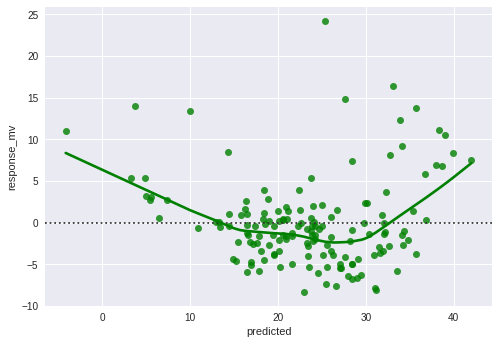

In [17]:
from sklearn.linear_model import Ridge

ridge1 = Ridge(alpha=.001, solver="cholesky").fit(X_train_R1,y_train_R1)

print("Training set score: {:.2f}".format(ridge1.score(X_train_R1,y_train_R1)))
print("Test set score: {:.2f}".format(ridge1.score(X_test_R1,y_test_R1)))
print("Number of features used: {}".format(np.sum(ridge1.coef_ !=0)))

y_R1_chk = y_test_R1.copy()
y_R1_chk['predicted']=ridge1.predict(X_test_R1)
# Plot the residuals after fitting a linear model
sns.residplot(y_R1_chk['predicted'], y_R1_chk['response_mv'], lowess=True, color="g")

### Model 1b Decision Tree
#### Training Score: .93 - Test Score: .84 (Max Depth = 5)
Observation - improved fit and simple - feature emphasis on 'avg_rooms'

In [0]:
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

In [0]:
# fit regression tree using model 1 training/test split
tree_model_fit = tree_model_maker.fit(X_train_R1, y_train_R1)

In [21]:
# compute the proportion of response variance for training data
X_train_R1_chk = X_train_R1.copy()

X_train_R1_chk['m1_Tree_predicted'] =\
    tree_model_fit.predict(X_train_R1_chk)
full_tree_train_result = \
    round(np.power(y_train_R1['response_mv']\
        .corr(X_train_R1_chk['m1_Tree_predicted']),2),3)
print('\nFull Tree Proportion of Training Set Variance Accounted for: ',\
    full_tree_train_result)

# compute the proportion of response variance for test data
X_test_R1_chk = X_test_R1.copy()

X_test_R1_chk['m1_Tree_predicted'] =\
    tree_model_fit.predict(X_test_R1_chk)
full_tree_test_result = \
    round(np.power(y_test_R1['response_mv']\
        .corr(X_test_R1_chk['m1_Tree_predicted']),2),3)
print('\nFull Tree Proportion of Test Set Variance Accounted for: ',\
    full_tree_test_result)


Full Tree Proportion of Training Set Variance Accounted for:  0.934

Full Tree Proportion of Test Set Variance Accounted for:  0.838


Training set score: 0.93
Test set score: 0.84


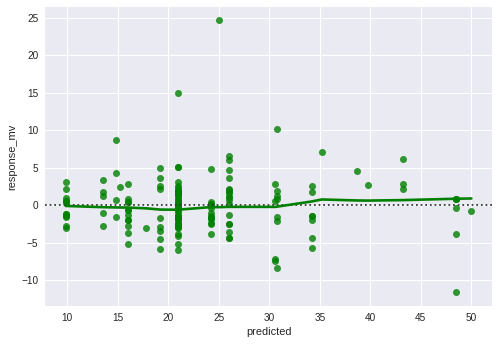

In [22]:
print("Training set score: {:.2f}".format(tree_model_fit.score(X_train_R1,y_train_R1)))
print("Test set score: {:.2f}".format(tree_model_fit.score(X_test_R1,y_test_R1)))
#print("Number of features used: {}".format(np.sum(tree_model_fit.coef_ !=0)))

y_Tree1_chk = y_test_R1.copy()
y_Tree1_chk['predicted']=tree_model_fit.predict(X_test_R1)
# Plot the residuals after fitting a linear model
sns.residplot(y_Tree1_chk['predicted'], y_Tree1_chk['response_mv'], lowess=True, color="g")

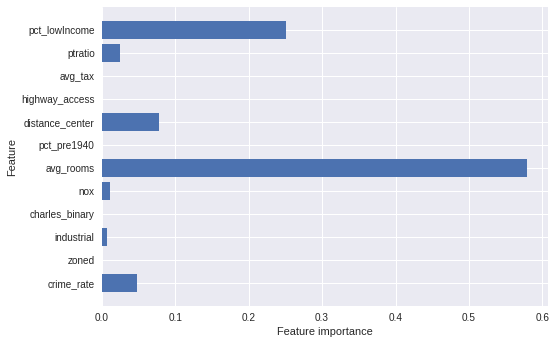

In [23]:
def plot_feature_importances_boston(model):
    n_features = X_train_R1.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_R1.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_boston(tree_model_fit)

### Model 1c - Random Forest Regressor
#### Training Score: .92 - Test Score: .87 (Max Depth = 4)
Observation - improved fit and less gap between train & test score
Feature emphasis changes from 'avg_rooms' to 'pct_lowIncome'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training set score: 0.92
Test set score: 0.87


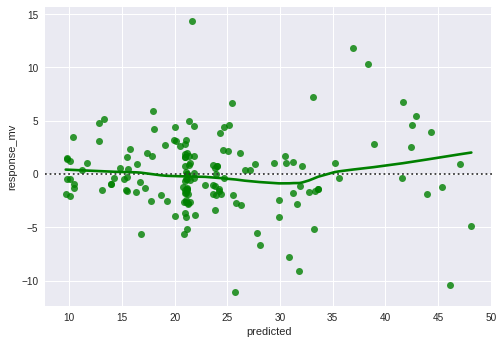

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

RForest1 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

RForest1.fit(X_train_R1,y_train_R1)

print("Training set score: {:.2f}".format(RForest1.score(X_train_R1,y_train_R1)))
print("Test set score: {:.2f}".format(RForest1.score(X_test_R1,y_test_R1)))
#print("Number of features used: {}".format(np.sum(tree_model_fit.coef_ !=0)))

y_RForest1_chk = y_test_R1.copy()
y_RForest1_chk['predicted']=RForest1.predict(X_test_R1)
# Plot the residuals after fitting a linear model
sns.residplot(y_RForest1_chk['predicted'], y_RForest1_chk['response_mv'], lowess=True, color="g")

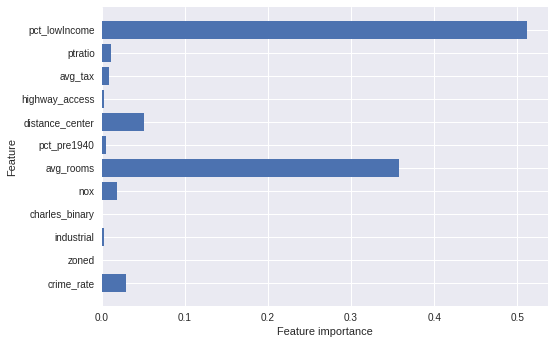

In [25]:
plot_feature_importances_boston(RForest1)

### Model 1d Gradient Boosting
#### Training Score: .95 - Test Score: .88 (Max Depth = 2)
Observation - 'best' fit for non-transformed data
improved distribution between feature emphasis

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train_R1,y_train_R1)

errors = [mean_squared_error(y_test_R1, y_pred)
          for y_pred in gbrt.staged_predict(X_test_R1)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train_R1,y_train_R1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=87, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Training set score: 0.95
Test set score: 0.88


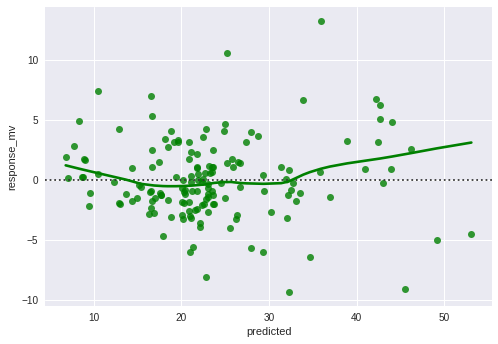

In [27]:
print("Training set score: {:.2f}".format(gbrt_best.score(X_train_R1,y_train_R1)))
print("Test set score: {:.2f}".format(gbrt_best.score(X_test_R1,y_test_R1)))
#print("Number of features used: {}".format(np.sum(tree_model_fit.coef_ !=0)))

y_gbrt_best_chk = y_test_R1.copy()
y_gbrt_best_chk['predicted']= gbrt_best.predict(X_test_R1)
# Plot the residuals after fitting a linear model
sns.residplot(y_gbrt_best_chk['predicted'], y_gbrt_best_chk['response_mv'], lowess=True, color="g")

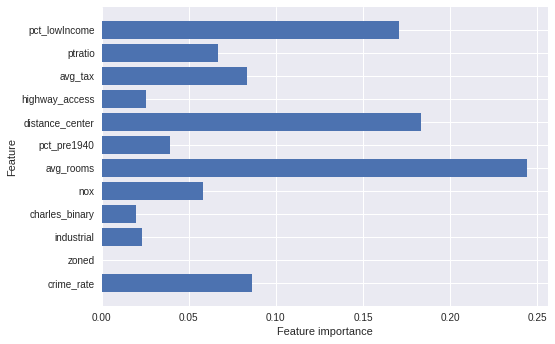

In [28]:
plot_feature_importances_boston(gbrt_best)

## Model 2 - Model exploration with data transformation (log)

### Model 2a - Regularized Linear Model (Ridge)

> #### Training Score: .78 - Test Score: .81 (12 features used)
Observation - poor fit & overly complex

### Model 2b - Decision Tree Regression Model


> #### Training Score: .87 - Test Score: .66 (Max Depth 4)
Observation - as max depth goes up, model is either over-simplified or over fit.. 


### Model 2c - Random Forest Regression Model


> #### Training Score: .91 - Test Score: .85 (Max Depth 4)
Observation - improvement on decision tree model - high feature emphasis on 'pct_lowIncome'


### Model 2d - Gradient Boosting for best fit


>#### Training Score: .94 - Test Score: .86 (Max Depth 2)
Observation - 'best' fit for transformed data set and good balance of emphasis across features


### Model 2 - Data Prep & Training/Test split
#### Log transformation to data & response

In [29]:
df_Boston_log = df_boston2.copy()
column_titles = df_boston2.columns

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

df_Boston_log = transformer.transform(df_Boston_log)
df_Boston_log = pd.DataFrame(df_Boston_log, columns = column_titles)
df_Boston_log.describe()

,crime_rate,zoned,industrial,charles_binary,nox,avg_rooms,pct_pre1940,distance_center,highway_access,avg_tax,ptratio,pct_lowIncome,response_mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.813418,0.953873,2.302089,0.047945,0.438587,1.981139,4.112104,1.479648,2.054483,5.934259,2.961462,2.475610,3.085473
std,1.022731,1.620831,0.663362,0.176055,0.072948,0.096500,0.589774,0.413390,0.751839,0.395337,0.117926,0.539033,0.386487
min,0.006300,0.000000,0.378436,0.000000,0.325700,1.517542,1.360977,0.755934,0.693147,5.236442,2.610070,1.004302,1.791759
25%,0.078853,0.000000,1.822935,0.000000,0.370874,1.929418,3.829184,1.131459,1.609438,5.634790,2.912351,2.073162,2.891757
50%,0.228336,0.000000,2.369309,0.000000,0.430483,1.975261,4.363095,1.436855,1.791759,5.802118,2.998226,2.514464,3.100092
75%,1.542674,2.602690,2.949688,0.000000,0.484892,2.031236,4.554666,1.822659,3.218876,6.502790,3.054001,2.887869,3.258097
max,4.499545,4.615121,3.358290,0.693147,0.626473,2.280339,4.615121,2.574633,3.218876,6.568078,3.135494,3.662792,3.931826


In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)    

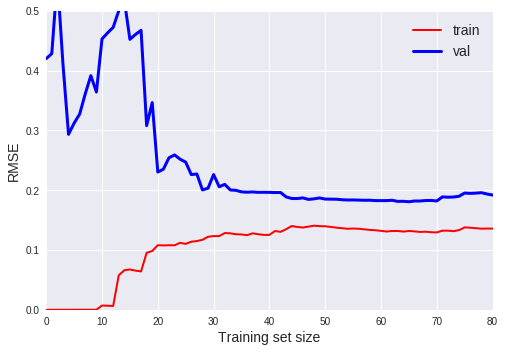

In [31]:
Log_model_X = df_Boston_log.copy()
Log_model_y = df_Boston_log.copy()

# split dataframe by data and response variables and make array for train_test_split
#remove response variable from data and save as df_data
Log_model_X = Log_model_X.drop(columns=['response_mv'])
#remove all but response variable and save as df_response
Log_model_y = pd.DataFrame(Log_model_y['response_mv'])

#'plot_learning_curves' defined under 'test model':
r_model = Ridge(alpha=.0001, solver="cholesky")
plot_learning_curves(r_model, Log_model_X, Log_model_y)
plt.axis([0, 80, 0, .5])                         # not shown in the book
plt.show()                                      # not shown

In [0]:
#split data by training & test sets
X_train_Log, X_test_Log, y_train_Log, y_test_Log = train_test_split(\
    Log_model_X, Log_model_y,test_size=.3, random_state=10)

In [0]:
X_train_Log.head(); #test split X

In [0]:
y_train_Log.head(); #test split y

### Model 2a - Scaled Ridge Regression (Log)
#### Training Score: .78 - Test Score: .81 (12 features used)
Observation - poor fit & overly complex

Training set score: 0.78
Test set score: 0.81
Number of features used: 12


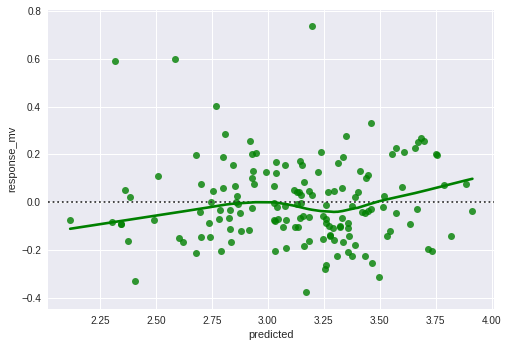

In [35]:
from sklearn.linear_model import Ridge

ridge2 = Ridge(alpha=1, solver="cholesky").fit(X_train_Log,y_train_Log)

print("Training set score: {:.2f}".format(ridge2.score(X_train_Log,y_train_Log)))
print("Test set score: {:.2f}".format(ridge2.score(X_test_Log,y_test_Log)))
print("Number of features used: {}".format(np.sum(ridge2.coef_ !=0)))

y_R2_chk = y_test_Log.copy()
y_R2_chk['predicted']=ridge2.predict(X_test_Log)
# Plot the residuals after fitting a linear model
sns.residplot(y_R2_chk['predicted'], y_R2_chk['response_mv'], lowess=True, color="g")

### Model 2b - Decision Tree Regression (Log)
#### Training Score: .87 - Test Score: .66 (Max Depth 4)
Observation - as max depth goes up, model is either over-simplified or over fit.. 

In [0]:
tree_model_maker2 = DecisionTreeRegressor(random_state = 9999, max_depth = 4)

In [0]:
# fit regression tree using model 1 training/test split
tree_model_fit2 = tree_model_maker2.fit(X_train_Log,y_train_Log)

Training set score: 0.87
Test set score: 0.66


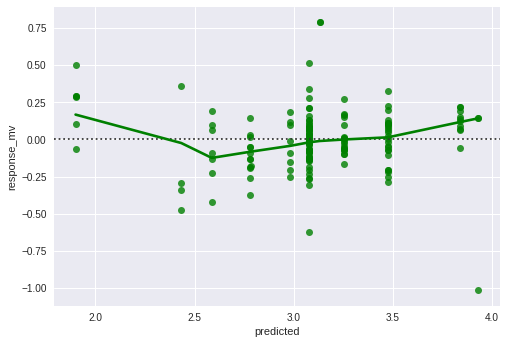

In [38]:
print("Training set score: {:.2f}".format(tree_model_fit2.score(X_train_Log,y_train_Log)))
print("Test set score: {:.2f}".format(tree_model_fit2.score(X_test_Log,y_test_Log)))
#print("Number of features used: {}".format(np.sum(tree_model_fit.coef_ !=0)))

y_Tree2_chk = y_test_Log.copy()

y_Tree2_chk['predicted']=tree_model_fit2.predict(X_test_Log)
# Plot the residuals after fitting a linear model
sns.residplot(y_Tree2_chk['predicted'], y_Tree2_chk['response_mv'], lowess=True, color="g")

In [39]:
print("Feature importances:\n{}".format(tree_model_fit2.feature_importances_))

Feature importances:
[0.11781841 0.         0.01747432 0.         0.00621571 0.23248833
 0.         0.04017902 0.         0.         0.         0.58582421]


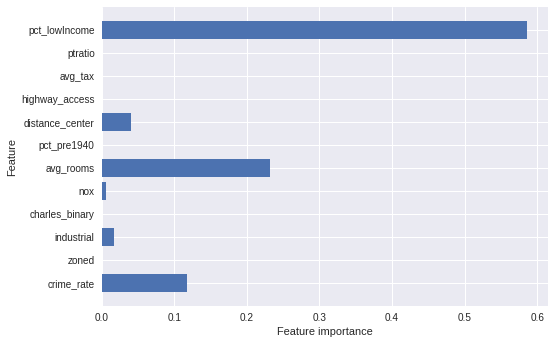

In [40]:
plot_feature_importances_boston(tree_model_fit2)

###Model 2c Random Forest
#### Training Score: .91 - Test Score: .85 (Max Depth 4)
Observation - improvement on decision tree model - high feature emphasis on 'pct_lowIncome'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Training set score: 0.91
Test set score: 0.85


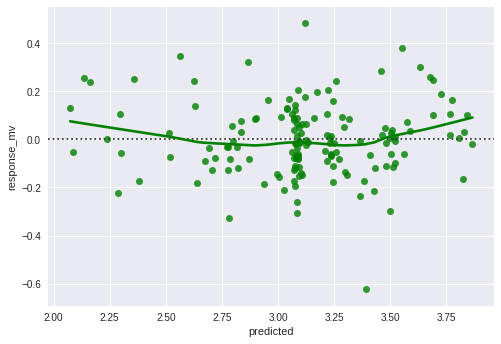

In [41]:
RForest2 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

RForest2.fit(X_train_Log,y_train_Log)

print("Training set score: {:.2f}".format(RForest2.score(X_train_Log,y_train_Log)))
print("Test set score: {:.2f}".format(RForest2.score(X_test_Log,y_test_Log)))
#print("Number of features used: {}".format(np.sum(tree_model_fit.coef_ !=0)))

y_RForest2_chk = y_test_Log.copy()
y_RForest2_chk['predicted']=RForest2.predict(X_test_Log)
# Plot the residuals after fitting a linear model
sns.residplot(y_RForest2_chk['predicted'], y_RForest2_chk['response_mv'], lowess=True, color="g")

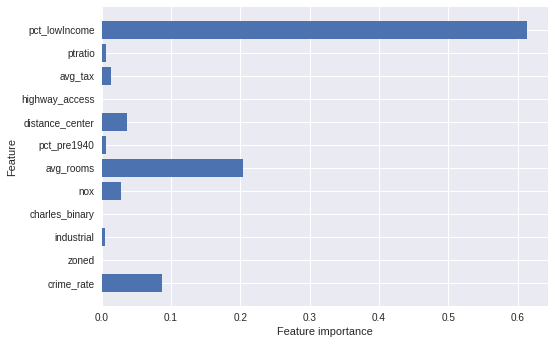

In [42]:
plot_feature_importances_boston(RForest2)

### Model 2d Gradient Boosting
#### Training Score: .94 - Test Score: .86 (Max Depth 2)
Observation - 'best' fit for transformed data set and good balance of emphasis across features

In [43]:
gbrt2 = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=42)
gbrt2.fit(X_train_Log,y_train_Log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Training set score: 0.94
Test set score: 0.86


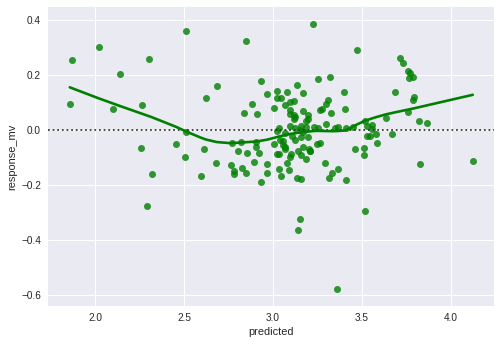

In [44]:
print("Training set score: {:.2f}".format(gbrt2.score(X_train_Log,y_train_Log)))
print("Test set score: {:.2f}".format(gbrt2.score(X_test_Log,y_test_Log)))

y_gbrt2_chk = y_test_Log.copy()
y_gbrt2_chk['predicted']=gbrt2.predict(X_test_Log)
# Plot the residuals after fitting a linear model
sns.residplot(y_gbrt2_chk['predicted'], y_gbrt2_chk['response_mv'], lowess=True, color="g")

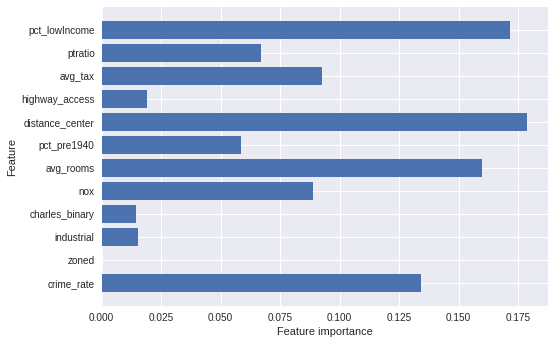

In [45]:
plot_feature_importances_boston(gbrt2)

## Conclusion

It appears that using a Gradient Boosting method works best in both the original data model and the transformed data.  By limiting the depth to Max Depth = 2, the model does not over-fit, and there is a good balance of emphasis across all the features in the model.

> ### Recommended model: Model 1d - Gradient Boosting with Max Depth 2

